<a href="https://colab.research.google.com/github/cfcastillo/DS-6-Notebooks/blob/main/2_Education_Capstone_EDA_and_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Definition

The purpose of this project is to identify what factors influence people to choose certain professions or trades. In understanding these factors, we can help colleges like Central New Mexico College (CNM) offer courses that support those professions and better target their marketing to people who are likely to choose those professions.

This project will be a supervised categorization problem using tree-based models to identify the factors that will contribute to career choice.



# References

[Oversampling and Undersampling](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/)

# Data Collection and Cleaning

The data collection and cleaning process is outlined in the notebook titled [1. Education Capstone - Data Collection and Cleaning.ipynb](https://colab.research.google.com/drive/1Y_1b7BmiRF6CSYnoiZqGpfjpbzU4qoFe#scrollTo=Kmxlgo4Wnjgd)


## Column Descriptions

[Here is a summary document showing selected columns.](https://docs.google.com/document/d/1io7TtqebJLtw6FKE7zkbUh26QkG3rEJrZX3Fver9zmU/edit)

# Imports

In [1]:
# grab the imports needed for the project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# import statsmodels.api as sm

from sklearn import metrics
from sklearn.metrics import classification_report
# import sklearn.model_selection as model_selection
# from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# from mlxtend.plotting import plot_decision_regions

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Visualization
import graphviz
# from IPython.display import display
# from sklearn import tree
# import plotly.express as px
# from ipywidgets import interact, Dropdown

# Other
# from sklearn.pipeline import Pipeline # Breaks if you use with over/under samplers
from imblearn.pipeline import Pipeline  # Need this pipeline to use over/under samplers

# Exploratory Data Analysis (EDA)

In our EDA, we will first filter our data to focus in on our features of interest and prepare our data for analysis. Then we will generate summary statistics to identify anomalies and visualize our data to better understand our variables and the relationships between them. Finally, we will reflect on the analysis and determine next steps.

##Import and filter data

We'll first import our clean dataset. We'll also be dropping some observations, such as those employed in the armed forces, who don't have enough observations to support significant analysis. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The team had different data links. The global here is to allow team members to specify who is working on this notebook so that they can run the code in their environment.

In [3]:
# Expected values are: ellie, amy, cecilia - lowercase
team_member = 'cecilia'

# Root drive path
if team_member in ['amy','ellie']:
  root_drive = '/content/drive/MyDrive/'
else: # Cecilia
  root_drive = '/content/drive/MyDrive/Student Folder - Cecilia/Projects/'

In [49]:
#Import final data
asec_final = pd.read_csv(root_drive + 'Capstone/Data/FinalData/Trends/asec_2019_trend_v4.csv')

In [50]:
asec_final.shape

(141251, 49)

## Additional Data Cleaning

In order to more balance the data, certain predictor values were dropped.

- A_CLSWKR = 0 or 8 - remove people who have never worked or those who are not in worker universe (i.e. in military, children)

In [51]:
#Drop 'Unnamed: 0' column
asec_final.drop('Unnamed: 0', axis=1, inplace=True)

# drop specified class of worker
wkr = [0,8]
asec_final.drop(asec_final[asec_final.A_CLSWKR.isin(wkr)].index, inplace=True)

In [52]:
asec_final.shape

(88453, 48)

In [53]:
# Balance the data by removing low occupation code counts. Data will then be over and undersampled
# as part of the modeling process.
which_target = 'A_DTOCC'
threshold = 2000

# get list of target values
occ_freq = asec_final[which_target].value_counts(ascending=False)
# drop certain occupational codes falling below specified threshold
df = pd.DataFrame(occ_freq)
occ_to_drop = df[df[which_target] < threshold].index
asec_final.drop(asec_final[asec_final[which_target].isin(occ_to_drop)].index, inplace=True)

## Understand our Data
To better understand our data we'll look at the general shape, values, and summarys statistics of the dataset.

In [54]:
#Get dimensions of datset
asec_final.shape

(78883, 48)

In [42]:
#Look at the first five rows
asec_final.head()

,DATA_YEAR,GTMETSTA,GEDIV,GESTFIPS,HHINC,H_TENURE,H_LIVQRT,OCCUP,POCCU2,A_MJOCC,A_DTOCC,AGE1,A_SEX,PRDTRACE,PXRACE1,PRCITSHP,A_HGA,PRERELG,A_GRSWK,HRCHECK,HRSWK,PEARNVAL,A_CLSWKR,WEIND,A_MARITL,A_HSCOL,A_WKSTAT,HEA,PEINUSYR,A_AGE,FINC_FR,FINC_SE,FINC_WS,FINC_CSP,FINC_DIS,FINC_DIV,FINC_RNT,FINC_ED,FINC_SS,FINC_SSI,FINC_FIN,FINC_SUR,FINC_INT,FINC_UC,FINC_OI,FINC_VET,FINC_PAW,FINC_WC
0,2019,2,1,23,8,1,5,4050,33,3,13,4,1,1,0,1,37,0,0,1,30,18000,1,18,7,0,4,3,0,21,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,2019,2,1,23,5,2,1,4020,32,3,13,13,2,1,0,1,39,0,0,2,44,12000,1,18,7,0,2,3,0,61,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4,2019,2,1,23,10,2,1,4610,37,3,15,8,1,1,0,1,39,0,0,1,20,12000,1,16,7,0,4,3,0,37,2,2,1,2,2,2,2,2,1,1,2,2,2,2,2,2,2,2
6,2019,2,1,23,23,1,1,4840,39,4,16,11,2,1,0,1,39,0,0,2,44,55000,1,8,5,0,2,2,0,53,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
10,2019,2,1,23,19,1,1,6420,46,7,19,11,1,1,0,1,43,0,0,2,50,45000,6,3,3,0,2,2,0,54,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [43]:
#Get info about each column
asec_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86693 entries, 0 to 141250
Data columns (total 48 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   DATA_YEAR  86693 non-null  int64
 1   GTMETSTA   86693 non-null  int64
 2   GEDIV      86693 non-null  int64
 3   GESTFIPS   86693 non-null  int64
 4   HHINC      86693 non-null  int64
 5   H_TENURE   86693 non-null  int64
 6   H_LIVQRT   86693 non-null  int64
 7   OCCUP      86693 non-null  int64
 8   POCCU2     86693 non-null  int64
 9   A_MJOCC    86693 non-null  int64
 10  A_DTOCC    86693 non-null  int64
 11  AGE1       86693 non-null  int64
 12  A_SEX      86693 non-null  int64
 13  PRDTRACE   86693 non-null  int64
 14  PXRACE1    86693 non-null  int64
 15  PRCITSHP   86693 non-null  int64
 16  A_HGA      86693 non-null  int64
 17  PRERELG    86693 non-null  int64
 18  A_GRSWK    86693 non-null  int64
 19  HRCHECK    86693 non-null  int64
 20  HRSWK      86693 non-null  int64
 21  PEARNVAL   

In [12]:
#Get summary statistics for each column
asec_final.describe()

,DATA_YEAR,GTMETSTA,GEDIV,GESTFIPS,HHINC,H_TENURE,H_LIVQRT,OCCUP,POCCU2,A_MJOCC,A_DTOCC,AGE1,A_SEX,PRDTRACE,PXRACE1,PRCITSHP,A_HGA,PRERELG,A_GRSWK,HRCHECK,HRSWK,PEARNVAL,A_CLSWKR,WEIND,A_MARITL,A_HSCOL,A_WKSTAT,HEA,PEINUSYR,A_AGE,FINC_FR,FINC_SE,FINC_WS,FINC_CSP,FINC_DIS,FINC_DIV,FINC_RNT,FINC_ED,FINC_SS,FINC_SSI,FINC_FIN,FINC_SUR,FINC_INT,FINC_UC,FINC_OI,FINC_VET,FINC_PAW,FINC_WC
count,78883.0,78883.00000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,7.888300e+04,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000,78883.000000
mean,2019.0,1.18265,5.451606,27.837139,31.080030,1.330135,1.174106,4080.576385,31.128507,4.114575,12.617940,9.042050,1.491145,1.515827,1.967483,1.654285,40.645158,0.215991,139.688919,1.748602,37.668294,5.268377e+04,1.742086,12.070205,3.391504,0.131701,2.502035,2.112394,3.039413,42.191042,1.978056,1.882839,1.045219,1.959370,1.983875,1.822573,1.922201,1.928768,1.863152,1.978614,1.988755,1.989237,1.303564,1.969702,1.974418,1.977245,1.990720,1.991975
std,0.0,0.41053,2.539753,16.268939,11.558703,0.488693,0.841505,2741.279211,16.394762,2.803076,6.914924,3.228295,0.499925,1.426446,7.688274,1.370654,2.601317,0.411511,433.320329,0.514089,13.457482,7.223288e+04,1.517073,5.873146,2.727056,0.475867,1.073433,0.935900,6.742210,14.395447,0.146501,0.321614,0.207785,0.197432,0.125958,0.382032,0.267856,0.257214,0.343689,0.144669,0.105443,0.103185,0.459799,0.171407,0.157886,0.149123,0.095883,0.089220
min,2019.0,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,-9.999000e+03,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,15.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2019.0,1.00000,3.000000,12.000000,22.000000,1.000000,1.000000,1240.000000,21.000000,2.000000,8.000000,7.000000,1.000000,1.000000,0.000000,1.000000,39.000000,0.000000,0.000000,2.000000,36.000000,2.000000e+04,1.000000,7.000000,1.000000,0.000000,2.000000,1.000000,0.000000,31.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2019.0,1.00000,5.000000,28.000000,37.000000,1.000000,1.000000,4230.000000,37.000000,3.000000,15.000000,9.000000,1.000000,1.000000,0.000000,1.000000,40.000000,0.000000,0.000000,2.000000,40.000000,3.800000e+04,1.000000,13.000000,1.000000,0.000000,2.000000,2.000000,0.000000,41.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,2019.0,1.00000,8.000000,42.000000,41.000000,2.000000,1.000000,5700.000000,43.000000,5.000000,17.000000,11.000000,2.000000,1.000000,0.000000,1.000000,43.000000,0.000000,0.000000,2.000000,40.000000,6.400000e+04,1.000000,16.000000,7.000000,0.000000,2.000000,3.000000,0.000000,53.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,2019.0,3.00000,9.000000,56.000000,41.000000,3.000000,12.000000,9840.000000,53.000000,10.000000,22.000000,17.000000,2.000000,26.000000,43.000000,5.000000,46.000000,1.000000,2885.000000,2.000000,99.000000,1.753999e+06,7.000000,23.000000,7.000000,2.000000,7.000000,5.000000,25.000000,85.000000,2.000000,2.000000,2

In [13]:
#See all column names
asec_final.columns

Index(['DATA_YEAR', 'GTMETSTA', 'GEDIV', 'GESTFIPS', 'HHINC', 'H_TENURE',
       'H_LIVQRT', 'OCCUP', 'POCCU2', 'A_MJOCC', 'A_DTOCC', 'AGE1', 'A_SEX',
       'PRDTRACE', 'PXRACE1', 'PRCITSHP', 'A_HGA', 'PRERELG', 'A_GRSWK',
       'HRCHECK', 'HRSWK', 'PEARNVAL', 'A_CLSWKR', 'WEIND', 'A_MARITL',
       'A_HSCOL', 'A_WKSTAT', 'HEA', 'PEINUSYR', 'A_AGE', 'FINC_FR', 'FINC_SE',
       'FINC_WS', 'FINC_CSP', 'FINC_DIS', 'FINC_DIV', 'FINC_RNT', 'FINC_ED',
       'FINC_SS', 'FINC_SSI', 'FINC_FIN', 'FINC_SUR', 'FINC_INT', 'FINC_UC',
       'FINC_OI', 'FINC_VET', 'FINC_PAW', 'FINC_WC'],
      dtype='object')

We are particularly interested in the column A_DTOCC, which indicates the detailed occupation codes grouped by industry, because this is the attributed we are interested in modeling. Theremore, some more EDA will be focused on this column.

In [44]:
#See unique values for target column, A_DTOCC
asec_final[which_target].unique()

array([13, 15, 16, 19, 22, 12,  2, 17,  6, 10,  1, 21,  8, 20, 14,  3,  4,
        9, 11,  7])

In [56]:
#See frequency for the target column
oc_freq = asec_final[which_target].value_counts(ascending=False)
oc_freq

1     10239
17     9913
16     8564
8      5638
22     5576
10     5204
13     5124
21     4964
19     4931
2      4236
14     3531
15     3479
20     2693
3      2682
11     2109
Name: A_DTOCC, dtype: int64

In [46]:
#See percentages for the A_DTOCC column
asec_final[which_target].value_counts(ascending=False, normalize=True)

1     0.118106
17    0.114346
16    0.098785
8     0.065034
22    0.064319
10    0.060028
13    0.059105
21    0.057260
19    0.056879
2     0.048862
14    0.040730
15    0.040130
20    0.031064
3     0.030937
11    0.024327
9     0.020451
4     0.020232
12    0.019263
6     0.018294
7     0.011846
Name: A_DTOCC, dtype: float64

##Plots

###Correlation
Correlation is only appropriate for continuous variables, so we'll create a subset of variables to evaluate using this method. 

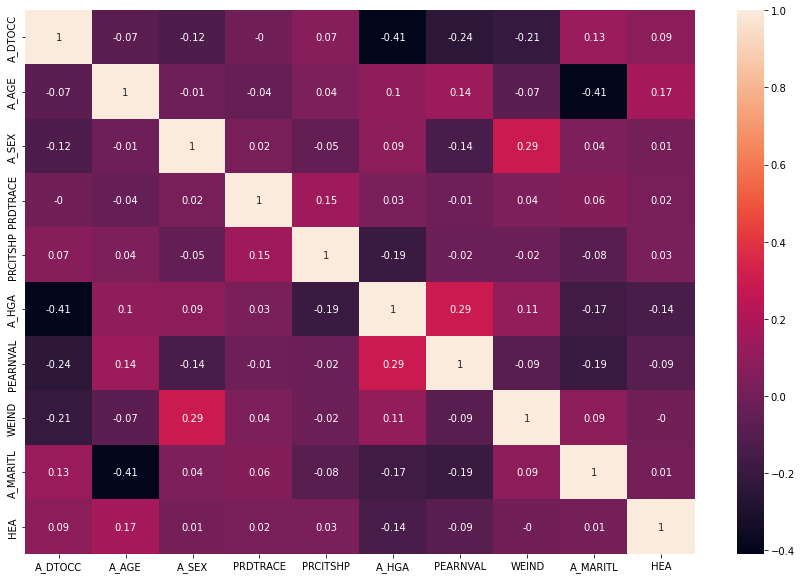

In [17]:
# Correlation plot
keep_cols = [which_target,'A_AGE', 'A_SEX', 'PRDTRACE', 'PRCITSHP', 'A_HGA', 'PEARNVAL', 'WEIND', 'A_MARITL', 'HEA']

correlation_df = asec_final.filter(items=keep_cols, axis=1)

plt.figure(figsize=(15,10))
correlation_matrix = correlation_df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)#, cmap='Blues')

In [18]:
# Numerically looking at the correlations
corrs = correlation_df.corr().round(2).unstack().abs()
corrs = corrs[(corrs < 1) & (corrs > 0.1)]
corrs.sort_values(ascending = False)

A_HGA     A_DTOCC     0.41
A_AGE     A_MARITL    0.41
A_MARITL  A_AGE       0.41
A_DTOCC   A_HGA       0.41
A_HGA     PEARNVAL    0.29
WEIND     A_SEX       0.29
PEARNVAL  A_HGA       0.29
A_SEX     WEIND       0.29
A_DTOCC   PEARNVAL    0.24
PEARNVAL  A_DTOCC     0.24
WEIND     A_DTOCC     0.21
A_DTOCC   WEIND       0.21
PEARNVAL  A_MARITL    0.19
A_HGA     PRCITSHP    0.19
A_MARITL  PEARNVAL    0.19
PRCITSHP  A_HGA       0.19
A_MARITL  A_HGA       0.17
A_HGA     A_MARITL    0.17
A_AGE     HEA         0.17
HEA       A_AGE       0.17
PRCITSHP  PRDTRACE    0.15
PRDTRACE  PRCITSHP    0.15
A_SEX     PEARNVAL    0.14
A_AGE     PEARNVAL    0.14
HEA       A_HGA       0.14
A_HGA     HEA         0.14
PEARNVAL  A_AGE       0.14
          A_SEX       0.14
A_DTOCC   A_MARITL    0.13
A_MARITL  A_DTOCC     0.13
A_SEX     A_DTOCC     0.12
A_DTOCC   A_SEX       0.12
A_HGA     WEIND       0.11
WEIND     A_HGA       0.11
dtype: float64

The following predictors show some level of correlation with occupation

- A_HGA (Education level) - Negative correlation because higher numbers relate to higher education level and lower occupation numbers relate to more professional work.
- PEARNVAL (earnings)

Other smaller correlations with occupation are
- A_MARITL (Marital status)
- A_SEX (sex)
- WEIND (Industry)

Finally there are some small correlations between other predictors.

- A_MARITL and A_AGE - marital status and age
- PEARNVAL and A_HGA - earnings and education
- WEIND and A_SEX - industry and sex
- PRCITSHP and A_HGA - citizenship and education level

###Boxplots
We use boxplots to visualize the categorical variability of occupational code against several continuous variables, including weekly earnings, total person's earnings, and weekly hours.

In [19]:
# TODO: Use pairplot instead to view all predictors and their distributions.
# Run analysis against the original target column
# sns.catplot(x="A_DTOCC", y="A_HGA", kind="box", data=asec_final, height=13)
# plt.title('Selected vs Coded Occupation')

In [20]:
# run analysis against the new target column
# sns.catplot(x="POCCU2", y="HRSWK", kind="box", data=asec_final, height=13)
# plt.title('Weekly Hours Worked vs Coded Occupation - Detailed')

##Reflection
The data are not normally distributed, but do show some interesting trends between our variables of interest (sex, occupational group, race, hours worked, etc). Depending on the model implemented, we may need to return to EDA to explicitly check assumptions for the model.

# Data Processing / Models


##Pre-processing: Balancing Classes
Because we're interested in predicting the occupation code of an individual based on their demographic data, it will be important to ensure all of our classes have equal representation in our training model. As it stands, our classes 1-22 range from a minimum of 871 observations (class 18) to a maximum of 10239 (class 1). To balance these classes, we'll randomly undersample all classes besides our minimum class. Depending on how well our model performs with the undersampled data, this method may need to be re-visited.

In [66]:
# Separating data into X and y data sets for applying models
# household_cols = ['GTMETSTA','GEDIV','GESTFIPS','HHINC','H_TENURE','H_LIVQRT']
household_cols = ['GEDIV','GESTFIPS','H_LIVQRT']
# person_cols = ['A_AGE', 'A_SEX', 'PRDTRACE', 'PRCITSHP', 'A_HGA', 'PEARNVAL', 'WEIND', 'A_MARITL', 'HEA']
person_cols = ['A_AGE', 'A_SEX', 'PRDTRACE', 'PRCITSHP', 'A_HGA', 'A_MARITL', 'HEA']
x_cols = person_cols + household_cols
X = asec_final[x_cols].copy()
y = asec_final[which_target].copy()

## Random Forest - Amy

[SK Learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [67]:
# TODO: We should change max depth for this and test again.
# Cross validation using oversampled data
# Creating a model and cross validating over it multiple times to see how many forest will be best to use

# sample methods = under, over, none
sample_method = 'under'

random_seed = 0
rus = RandomUnderSampler(random_state=random_seed)
ros = RandomOverSampler(random_state=random_seed)
num_trees = range(10,101,10)
cv_loops = 5
results = np.zeros(len(num_trees))

for n, trees in enumerate(num_trees):
  accuracy_cv = np.zeros(cv_loops)
  for i in range(cv_loops):
    # define the model
    rfModel = RandomForestClassifier(n_estimators=trees, random_state=random_seed)

    # assemble the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    if sample_method == 'under':
      X_train_samp, y_train_samp = rus.fit_resample(X_train, y_train)
    elif sample_method == 'over':
      X_train_samp, y_train_samp = ros.fit_resample(X_train, y_train)

    # fit the model
    if sample_method == 'none':
      rfModel.fit(X_train, y_train)
    else:
      X_train_samp_df = pd.DataFrame(X_train_samp, columns=X_train.columns, dtype=float)
      rfModel.fit(X_train_samp_df, y_train_samp)

    # capture model performance
    y_pred_rf = rfModel.predict(X_test)
    accuracy_cv[i] = accuracy_score(y_pred_rf, y_test)

  # Record average accuracy so we can then get the optimal one
  results[n] = accuracy_cv.mean().round(3)

# Print result so we can see which tree count provided best RMSE
print(f"CV Accuracy by Tree Count:\n")
for n, trees in enumerate(num_trees):
  print(f'Trees={num_trees[n]} | Accuracy={results[n]}')
  if results[n] == results.max():
    optimal_trees = num_trees[n]
    optimal_accuracy = results[n]
    print(f'Optimal Trees={optimal_trees}')

CV Accuracy by Tree Count:

Trees=10 | Accuracy=0.156
Trees=20 | Accuracy=0.162
Trees=30 | Accuracy=0.162
Trees=40 | Accuracy=0.163
Trees=50 | Accuracy=0.163
Trees=60 | Accuracy=0.164
Trees=70 | Accuracy=0.165
Trees=80 | Accuracy=0.165
Trees=90 | Accuracy=0.167
Optimal Trees=90
Trees=100 | Accuracy=0.165


In [68]:
# Re-running the RF model with the suggested number of trees
model = RandomForestClassifier(n_estimators = optimal_trees, random_state=random_seed) 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

if sample_method == 'none':
  model.fit(X_train,y_train)
else:
  if sample_method == 'under':
    X_train_samp, y_train_samp = rus.fit_resample(X_train, y_train)
  else:
    X_train_samp, y_train_samp = rus.fit_resample(X_train, y_train)
  
  X_train_samp_df = pd.DataFrame(X_train_samp, columns=X_train.columns, dtype=float)
  model.fit(X_train_samp_df, y_train_samp)

y_pred_rf = model.predict(X_test)

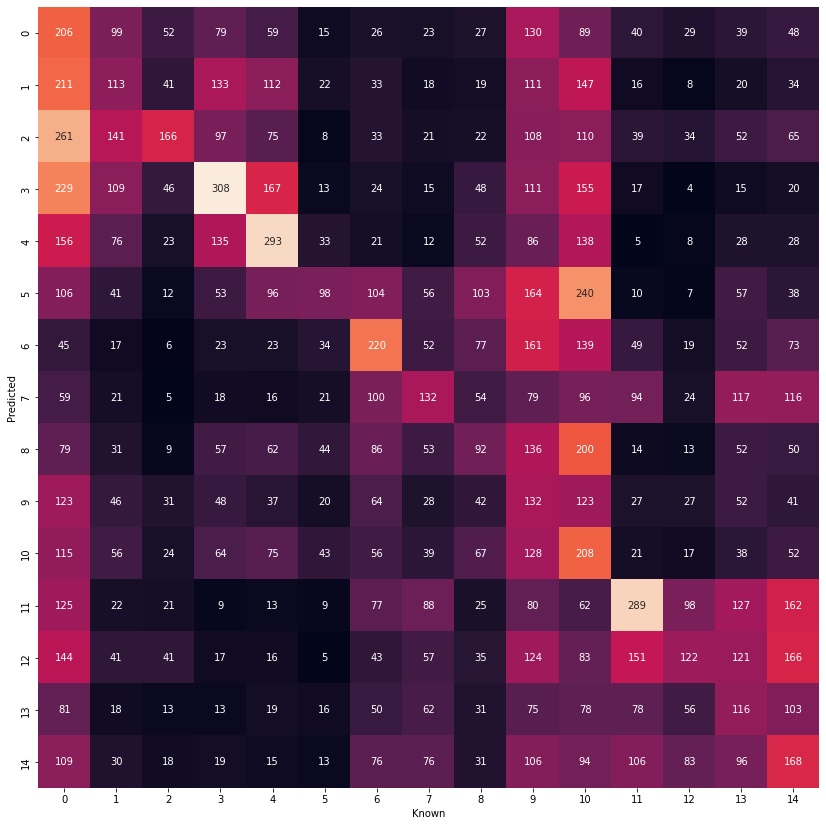

In [69]:
# Confusion matrix for random forest results
# TODO: How to get the actual values for each item. Need to map index values with real values.
plt.figure(figsize=(14,36))
mat = metrics.confusion_matrix(y_test,y_pred_rf)
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
# ax.set_xticklabels(ax.get_xticklabels)
# ax.set_yticklabels(ax.get_yticklabels)
            # xticklabels=range(1,23), yticklabels=range(1,23))
plt.xlabel('Known')
plt.ylabel('Predicted');

In [70]:
# Classification report for random forest results.
labels = list(map(str, range(1,16)))
classification_result = classification_report(y_test, y_pred_rf, target_names=labels)
print(classification_result)

              precision    recall  f1-score   support

           1       0.21      0.10      0.14      2049
           2       0.11      0.13      0.12       861
           3       0.13      0.33      0.19       508
           4       0.24      0.29      0.26      1073
           5       0.27      0.27      0.27      1078
           6       0.08      0.25      0.12       394
           7       0.22      0.22      0.22      1013
           8       0.14      0.18      0.16       732
           9       0.09      0.13      0.11       725
          10       0.16      0.08      0.10      1731
          11       0.21      0.11      0.14      1962
          12       0.24      0.30      0.27       956
          13       0.10      0.22      0.14       549
          14       0.14      0.12      0.13       982
          15       0.16      0.14      0.15      1164

    accuracy                           0.17     15777
   macro avg       0.17      0.19      0.17     15777
weighted avg       0.18   

In [26]:
# Visualization for the Random Forest
# display(graphviz.Source(tree.export_graphviz(rfModel.estimators_[0], feature_names=X.columns)))

Text(0, 0.5, 'Feature Importance Score')

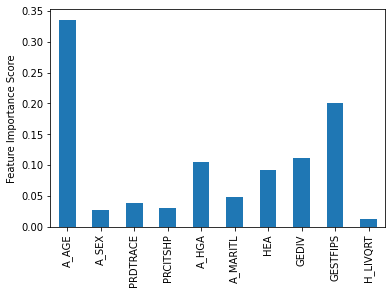

In [71]:
importances = rfModel.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

plt.figure()
forest_importances.plot.bar()
plt.ylabel("Feature Importance Score")

## XG Boost - Ellie/Cecilia

[XG Boost Documentation](https://xgboost.readthedocs.io/en/stable/tutorials/index.html)

[Grid Search CV documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

[Class notebook on XG Boost](https://colab.research.google.com/drive/1q1xJOKgVCM-BYfrarCdk4EgE42ZUdVEO)

[Class lecture on XG Boost](https://docs.google.com/presentation/d/1rEi9AKVslEAzyskRPbKWRfGikhcfFfmU/edit#slide=id.p1)



In [ ]:
# XG Boost work in progress
# random_seed = 0
# rus = RandomUnderSampler(random_state=random_seed)
# ros = RandomOverSampler(random_state=random_seed)
# cv_loops = 5
# accuracy_cv = np.zeros(cv_loops)

# for i in range(cv_loops):
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
#   # X_train_samp, y_train_samp = ros.fit_resample(X_train, y_train)
#   # X_train_samp_df = pd.DataFrame(X_train_samp, columns=X_train.columns, dtype=float)

#   xgbc = xgb.XGBClassifier(objective ='multi:softmax', verbosity=0, seed = 10, learning_rate=0.3)
#   # xgbc.fit(X_train_samp, y_train_samp)
#   xgbc.fit(X_train, y_train)
#   y_pred_xgb = xgbc.predict(X_test)

#   accuracy_cv[i] = accuracy_score(y_pred_xgb, y_test)

# # Print result so we can see which tree count provided best RMSE
# print(f"CV Accuracy for XG Boost: {accuracy_cv.mean().round(3)}")

In [30]:
# XGB testing parameters
values, counts = np.unique(y, return_counts=True)
class_count = len(values)

param_test = {
  'max_depth': range(1,8),
  'learning_rate' : [0.1, 0.2, 0.3, 0.4], 
  'n_estimators': range(10,41,10),
  'class_count': class_count
}

# Perform the grid search
gsearch = GridSearchCV(estimator = xgb.XGBClassifier(objective = 'multi:softmax', seed = 10), 
 param_grid = param_test, scoring='accuracy', cv=5)

# Fit to training data 
X_train, X_test, y_train, y_test = train_test_split(X_xgb,Y_xgb,test_size=0.20)

# if sampling
X_train_samp, y_train_samp = ros.fit_resample(X_train, y_train)
X_train_samp_df = pd.DataFrame(X_train_samp, columns=X_train.columns, dtype=float)
model = gsearch.fit(X_train_samp_df,y_train_samp)

# if not sampling
# model = gsearch.fit(X_train, y_train)

# See grid search results
print(model.best_params_)

In [29]:
# Classification Report for XG Boost
# labels = list(map(str, range(1,23)))
# classification_result = classification_report(y_test_xgb, y_pred_xgb, target_names=labels)
# print(classification_result)

I'm wondering if one way to address the model's poor accuracy for some classes is to remove some of the advanced occupation codes. Perhaps we could try the model again after removing class 5 (Life, physical, and social science occupations)?

In [31]:
#Determine feature importance

# feat_imp = pd.Series(xgbc.feature_importances_, index=X_xgb.columns)
# plt.figure(figsize = (10,6))
# ax = sns.barplot(x = feat_imp.index, y = feat_imp.values)
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
# plt.xlabel('Feature')
# plt.ylabel('Feature Importance Score')

Important features include 
- A_MJOCC : Major occupation recode (this seems like a type of duplicate of our target variable, A_DTCC? Not sure this should be included in our dataset)
- WEIND : index of longest job by detailed codes (this also seems like a duplicate, not sure this should be included)
- A_HGA : Education Attainment
- A_SEX : Sex
- HRCHECK : Employed full or part time

# Data Processing Using Pipelines - Cecilia

Want to use GridSearchCV for hyperparameter optimization. Data did not require imputation because it was already in an encoded/imputed state as provided by the ASEC website.

[SK Learn Documentation on Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

[Class notes on Pipelines](https://colab.research.google.com/drive/15k8pO0FZrEnkgAN8Zxc8E_21TT5sjsxl)


## Pipeline All Models

In [236]:
# Get view of classes so we can pass as parameter to models
values, counts = np.unique(y, return_counts=True)
class_count = len(values)
print(values)
print(counts)
print(class_count)


[ 1  2  3  8 10 11 13 14 15 16 17 19 20 21 22]
[10239  4236  2682  5638  5204  2109  5124  3531  3479  8564  9913  4931
  2693  4964  5576]
15


In [242]:
# TODO: if I use gridsearch, can I pass in my oversampled/undersampled dataset?
random_seed = 0
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

# TODO: look at using sampling_strategy parameter
rus = RandomUnderSampler(random_state=random_seed)
ros = RandomOverSampler(random_state=random_seed)
dtc = DecisionTreeClassifier(random_state=random_seed)
rfc = RandomForestClassifier(random_state=random_seed)
xgbc = xgb.XGBClassifier()

pipe = Pipeline(steps=[("sampler", rus), ("classifier", xgbc)])
# pipe = Pipeline(steps=[("classifier", dtc)])
# pipe = Pipeline(steps=[("classifier", xgbc)])

# to get it to run
# - try undersampler only
# - reducing range for nestimators
# - after complete - run it with test data


parameters = [
  {
    "sampler": [rus]
  },
  # {
  #   "classifier": [dtc],
  #   "classifier__max_depth": range(1,10)
  # },
  # {
  #   "classifier": [rfc],
  #   "classifier__n_estimators": range(10,101,10),
    # "classifier__max_depth": range(1,10)
  # },
  {
    "classifier": [xgbc],
    "classifier__objective": ["multi:softmax"],
    "classifier__verbosity": [0],
    "classifier__seed": [10],
    "classifier__learning_rate": [0.1, 0.2, 0.3, 0.4],
    "classifier__n_estimators": range(10,41,10),
    "classifier__max_depth": range(1,8),
    "classifier__num_class": [class_count]
  }
]

# Try recall instead of accuracy to deal with unbalanced classes
grid = GridSearchCV(estimator=pipe, param_grid=parameters, scoring='accuracy', cv=5, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampler',
                                        RandomUnderSampler(random_state=0)),
                                       ('classifier',
                                        XGBClassifier(learning_rate=0.2,
                                                      max_depth=6,
                                                      n_estimators=40,
                                                      num_class=15,
                                                      objective='multi:softmax',
                                                      seed=10, verbosity=0))]),
             param_grid=[{'sampler': [RandomUnderSampler(random_state=0)]},
                         {'classifier': [XGBClassifier(learning_rate=0.2,
                                                       max_depth=6,
                                                       n_...
                                                       num_class=15,
           

In [243]:
grid.best_score_

0.22764874236374624

In [244]:
grid.best_estimator_

Pipeline(steps=[('sampler', RandomUnderSampler(random_state=0)),
                ('classifier',
                 XGBClassifier(learning_rate=0.2, max_depth=6, n_estimators=40,
                               num_class=15, objective='multi:softprob',
                               seed=10, verbosity=0))])

In [245]:
grid.best_params_

{'classifier': XGBClassifier(learning_rate=0.2, max_depth=6, n_estimators=40, num_class=15,
               objective='multi:softmax', seed=10, verbosity=0),
 'classifier__learning_rate': 0.2,
 'classifier__max_depth': 6,
 'classifier__n_estimators': 40,
 'classifier__num_class': 15,
 'classifier__objective': 'multi:softmax',
 'classifier__seed': 10,
 'classifier__verbosity': 0}

In [ ]:
# grid.cv_results_